# Author: Yichun Ren

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### diabetes_data.csv is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_012 has 3 classes. 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes. There is class imbalance in this dataset. This dataset has 21 feature variables.

In [2]:
# read dataset
df = pd.read_csv('diabetes_data.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
# take a look at the number of observations and variables
df.shape

(253680, 22)

In [4]:
# check data types
# The data types of columns are desirable, so there is no need to transform them.
# However, some of them are numeric features and some of them are Categorical features.
df.dtypes

Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [5]:
# check number of null values in each column
# No null value. No need to drop/replace them.
df.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [6]:
###Attention: we remove case 1 and keep only no daibetes/diabetes
df = df[df['Diabetes_012'] != 1]
df['Diabetes'] = df['Diabetes_012'].map({2:1, 0:0})
df = df.drop(['Diabetes_012'], axis = 1)
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,0


# Analyze Features

## - Target Variable: Diabetes
    - 0 = no diabetes 
    - 1 = diabetes
    
**The class in unbalanced, we need to pay attention to it when we build model.**

Text(0.5, 1.0, 'Diabetes Distribution')

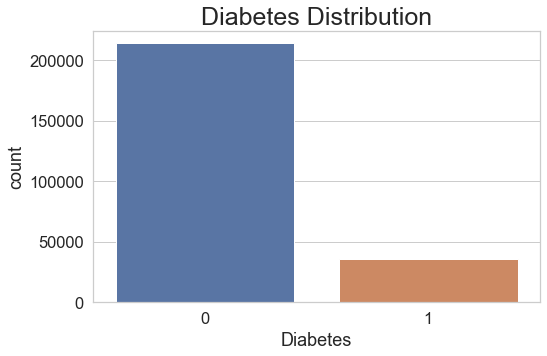

In [7]:
# turn value counts into a dataframe
diabetes = df['Diabetes'].value_counts().to_frame().reset_index()
diabetes = diabetes.rename(columns={'index': 'Diabetes', 'Diabetes': 'count'})

# plot the distribution
sns.set(style='whitegrid', font_scale=1.5)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Diabetes', y='count', data=diabetes)
ax.axes.set_title('Diabetes Distribution', fontsize=25)

## Check the distributions of features
### We group the features into categorical/numeric features

In [8]:
cat_feat = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
           'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 
           'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
num_feat = ['BMI', 'MentHlth', 'PhysHlth']

## Categorical

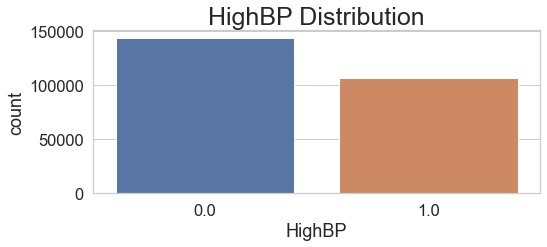

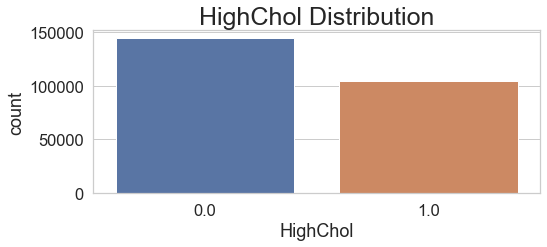

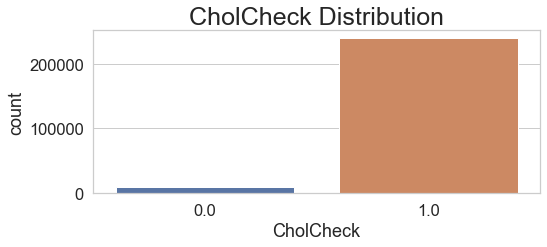

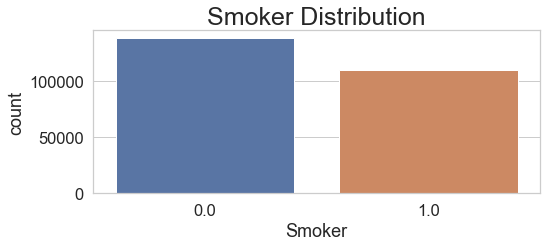

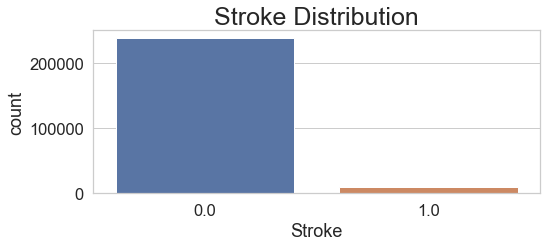

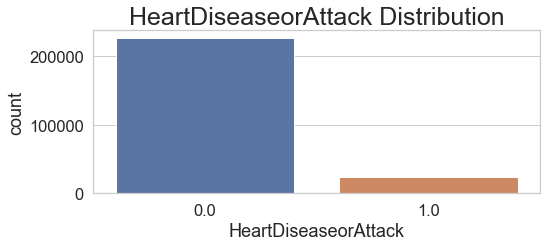

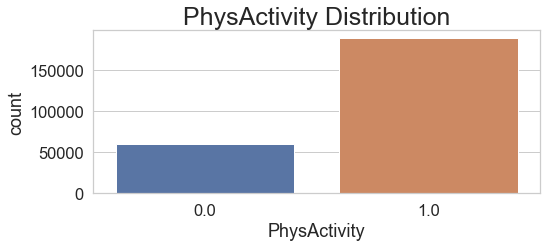

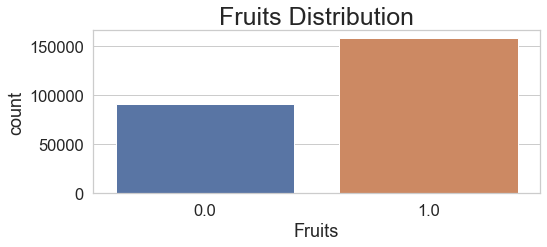

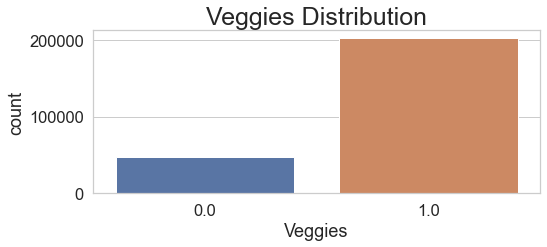

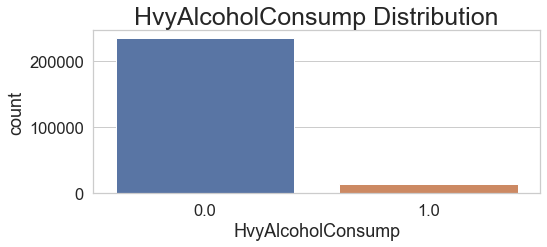

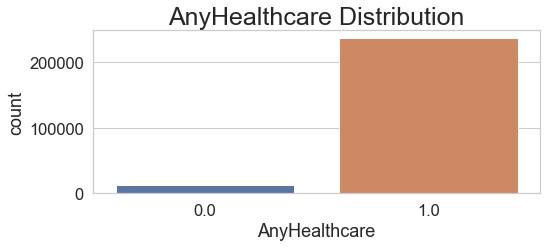

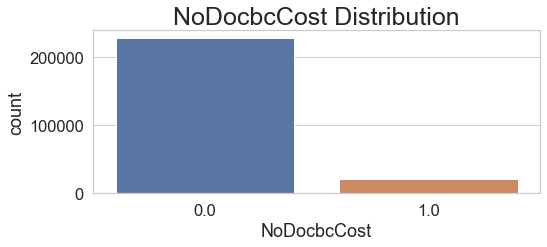

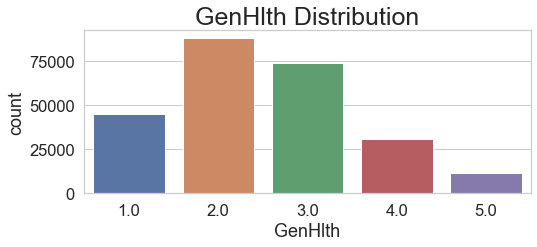

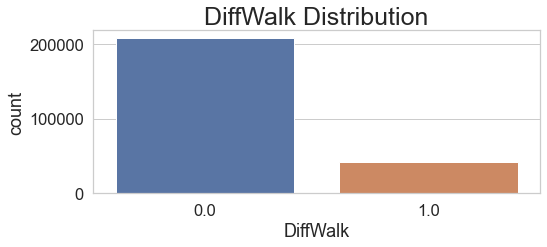

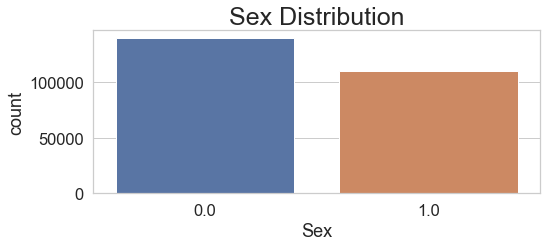

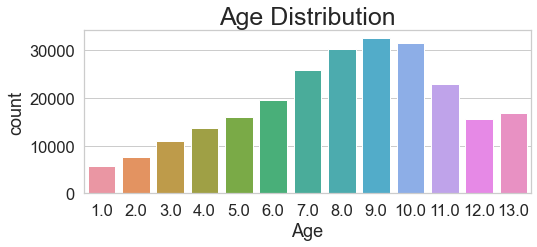

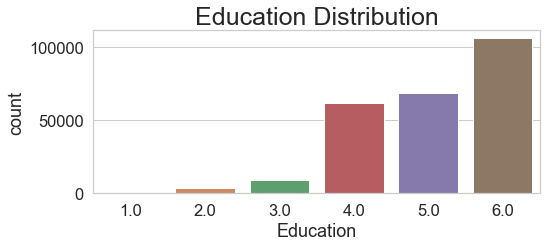

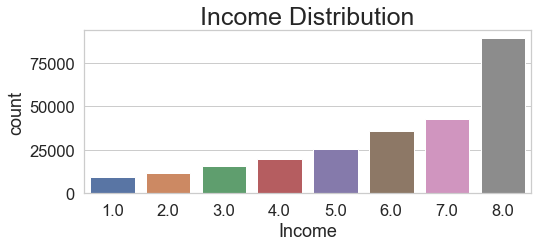

In [9]:
for cat in cat_feat:
    # turn value counts into a dataframe
    diabetes = df[cat].value_counts().to_frame().reset_index()
    diabetes = diabetes.rename(columns={'index': cat, cat: 'count'})

    # plot the distribution
    sns.set(style='whitegrid', font_scale=1.5)
    plt.figure(figsize=(8, 3))
    ax = sns.barplot(x=cat, y='count', data=diabetes)
    ax.axes.set_title(cat + ' Distribution', fontsize=25)

### We notice that most features are unbalanced. 

### Numeric Features

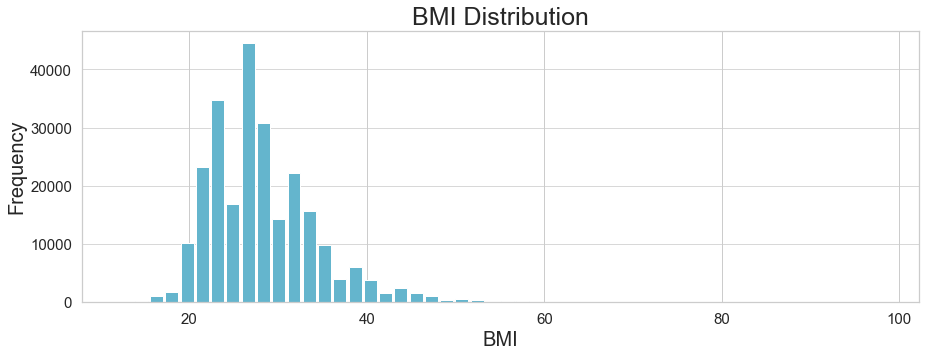

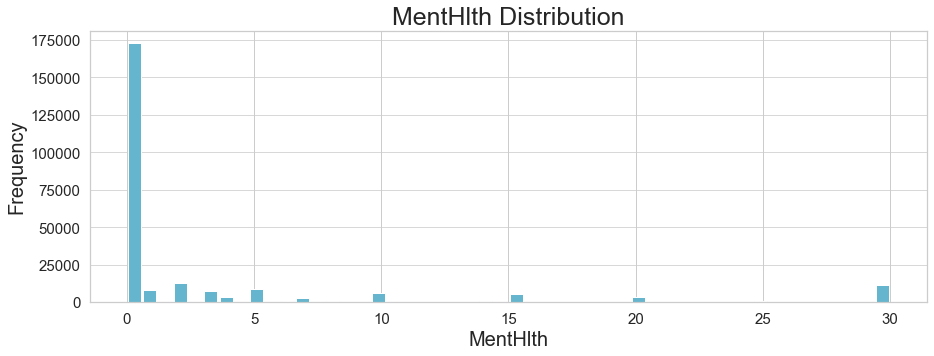

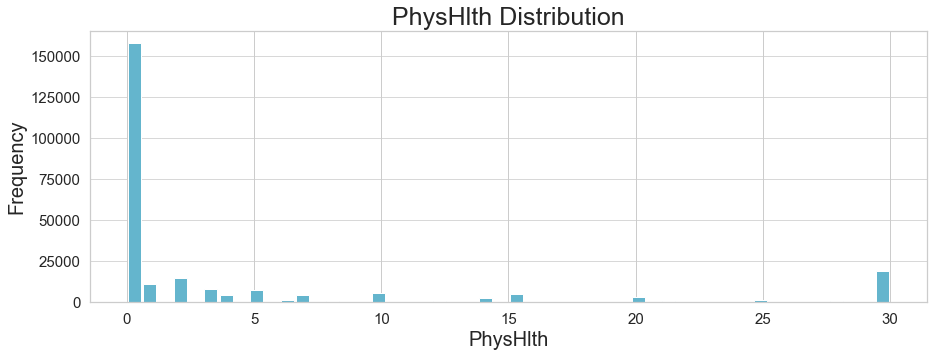

In [10]:
for num in num_feat:
    plt.figure(figsize=[15,5])
    n, bins, patches = plt.hist(x=df[num], 
                                color='c', bins=50, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(num, fontsize=20)
    plt.ylabel('Frequency',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title( num + ' Distribution',fontsize=25)
    plt.show()

### BMI is nearly bell-shaped and right skewed.
### Menthlth/PhysHlth is extremely right-skewed. Since the values are scattered, they could be used as categorical features as well.

# Relationship between Categorical features and Diabetes

## Categorical
### As we can see, for some features, the positive rates are significantly different for different classes.

In [11]:
#method 1
#aggre_df = df.groupby(['Diabetes', 'HighBP']).count()
#aggre_df = aggre_df[[aggre_df.columns[0]]]
#aggre_df = aggre_df.rename(columns={aggre_df.columns[0]: "count"})
#aggre_df.head()

In [12]:
#method 2
for cat in cat_feat:
    aggre_df = pd.DataFrame(pd.crosstab(index = df[cat], columns = df['Diabetes']))
    aggre_df['count'] = aggre_df.apply(np.sum, axis=1)
    aggre_df['0_rate'] = aggre_df[0.0]/aggre_df['count']
    aggre_df['1_rate'] = aggre_df[1.0]/aggre_df['count']
    #aggre_df['2_rate'] = aggre_df[2.0]/aggre_df['count']
    display(aggre_df)

Diabetes,0,1,count,0_rate,1_rate
HighBP,,,,,
0.0,134391,8742,143133,0.938924,0.061076
1.0,79312,26604,105916,0.748820,0.251180


Diabetes,0,1,count,0_rate,1_rate
HighChol,,,,,
0.0,132673,11660,144333,0.919215,0.080785
1.0,81030,23686,104716,0.773807,0.226193


Diabetes,0,1,count,0_rate,1_rate
CholCheck,,,,,
0.0,9167,241,9408,0.974384,0.025616
1.0,204536,35105,239641,0.853510,0.146490


Diabetes,0,1,count,0_rate,1_rate
Smoker,,,,,
0.0,121879,17029,138908,0.877408,0.122592
1.0,91824,18317,110141,0.833695,0.166305


Diabetes,0,1,count,0_rate,1_rate
Stroke,,,,,
0.0,206944,32078,239022,0.865795,0.134205
1.0,6759,3268,10027,0.674080,0.325920


Diabetes,0,1,count,0_rate,1_rate
HeartDiseaseorAttack,,,,,
0.0,198352,27468,225820,0.878363,0.121637
1.0,15351,7878,23229,0.660855,0.339145


Diabetes,0,1,count,0_rate,1_rate
PhysActivity,,,,,
0.0,47212,13059,60271,0.783329,0.216671
1.0,166491,22287,188778,0.881941,0.118059


Diabetes,0,1,count,0_rate,1_rate
Fruits,,,,,
0.0,76287,14653,90940,0.838872,0.161128
1.0,137416,20693,158109,0.869122,0.130878


Diabetes,0,1,count,0_rate,1_rate
Veggies,,,,,
0.0,38159,8610,46769,0.815904,0.184096
1.0,175544,26736,202280,0.867827,0.132173


Diabetes,0,1,count,0_rate,1_rate
HvyAlcoholConsump,,,,,
0.0,200487,34514,235001,0.853133,0.146867
1.0,13216,832,14048,0.940774,0.059226


Diabetes,0,1,count,0_rate,1_rate
AnyHealthcare,,,,,
0.0,10741,1422,12163,0.883088,0.116912
1.0,202962,33924,236886,0.856792,0.143208


Diabetes,0,1,count,0_rate,1_rate
NoDocbcCost,,,,,
0.0,196690,31604,228294,0.861564,0.138436
1.0,17013,3742,20755,0.819706,0.180294


Diabetes,0,1,count,0_rate,1_rate
GenHlth,,,,,
1.0,43846,1140,44986,0.974659,0.025341
2.0,81489,6381,87870,0.927381,0.072619
3.0,60461,13457,73918,0.817947,0.182053
4.0,20755,9790,30545,0.679489,0.320511
5.0,7152,4578,11730,0.609719,0.390281


Diabetes,0,1,count,0_rate,1_rate
DiffWalk,,,,,
0.0,185434,22225,207659,0.892974,0.107026
1.0,28269,13121,41390,0.682991,0.317009


Diabetes,0,1,count,0_rate,1_rate
Sex,,,,,
0.0,120959,18411,139370,0.867898,0.132102
1.0,92744,16935,109679,0.845595,0.154405


Diabetes,0,1,count,0_rate,1_rate
Age,,,,,
1.0,5601,78,5679,0.986265,0.013735
2.0,7404,140,7544,0.981442,0.018558
3.0,10737,314,11051,0.971586,0.028414
4.0,13055,626,13681,0.954243,0.045757
5.0,14943,1051,15994,0.934288,0.065712
6.0,17765,1742,19507,0.910699,0.089301
7.0,22808,3088,25896,0.880754,0.119246
8.0,26019,4263,30282,0.859223,0.140777
9.0,26809,5733,32542,0.823828,0.176172


Diabetes,0,1,count,0_rate,1_rate
Education,,,,,
1.0,125,47,172,0.726744,0.273256
2.0,2699,1183,3882,0.695260,0.304740
3.0,6868,2296,9164,0.749454,0.250546
4.0,50334,11066,61400,0.819772,0.180228
5.0,58223,10354,68577,0.849016,0.150984
6.0,95454,10400,105854,0.901751,0.098249


Diabetes,0,1,count,0_rate,1_rate
Income,,,,,
1.0,7114,2383,9497,0.749079,0.250921
2.0,8341,3086,11427,0.729938,0.270062
3.0,12005,3568,15573,0.770886,0.229114
4.0,15622,4054,19676,0.793962,0.206038
5.0,20792,4504,25296,0.821948,0.178052
6.0,30431,5291,35722,0.851884,0.148116
7.0,37219,5265,42484,0.876071,0.123929
8.0,82179,7195,89374,0.919496,0.080504


## Numeric
### As we can see, the distributions of features are different for diabetes and no diabetes

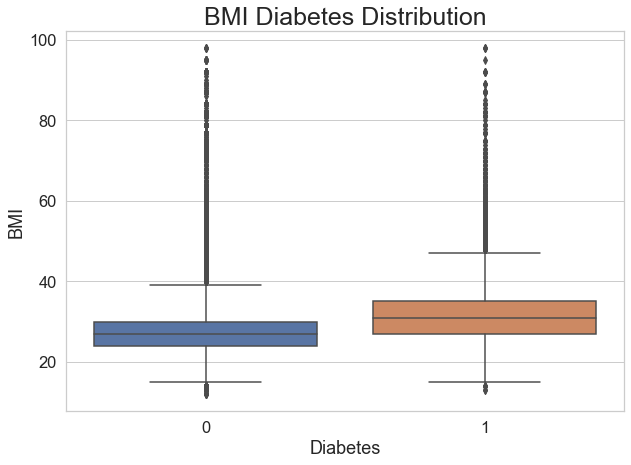

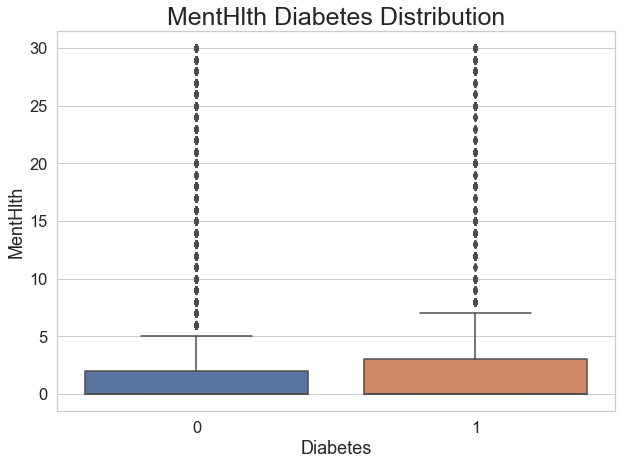

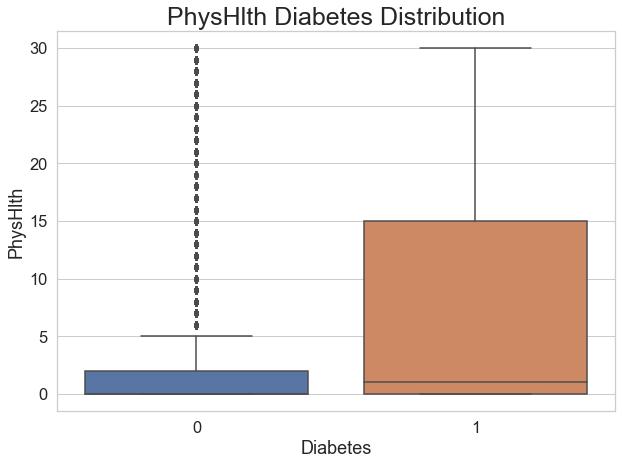

In [13]:
for num in num_feat:
    sns.set(style='whitegrid', font_scale=1.5)
    plt.figure(figsize=(10, 7))
    ax = sns.boxplot(x='Diabetes', y=num, data=df)
    ax.axes.set_title(num +' Diabetes Distribution', fontsize=25)

## Compute correlation 

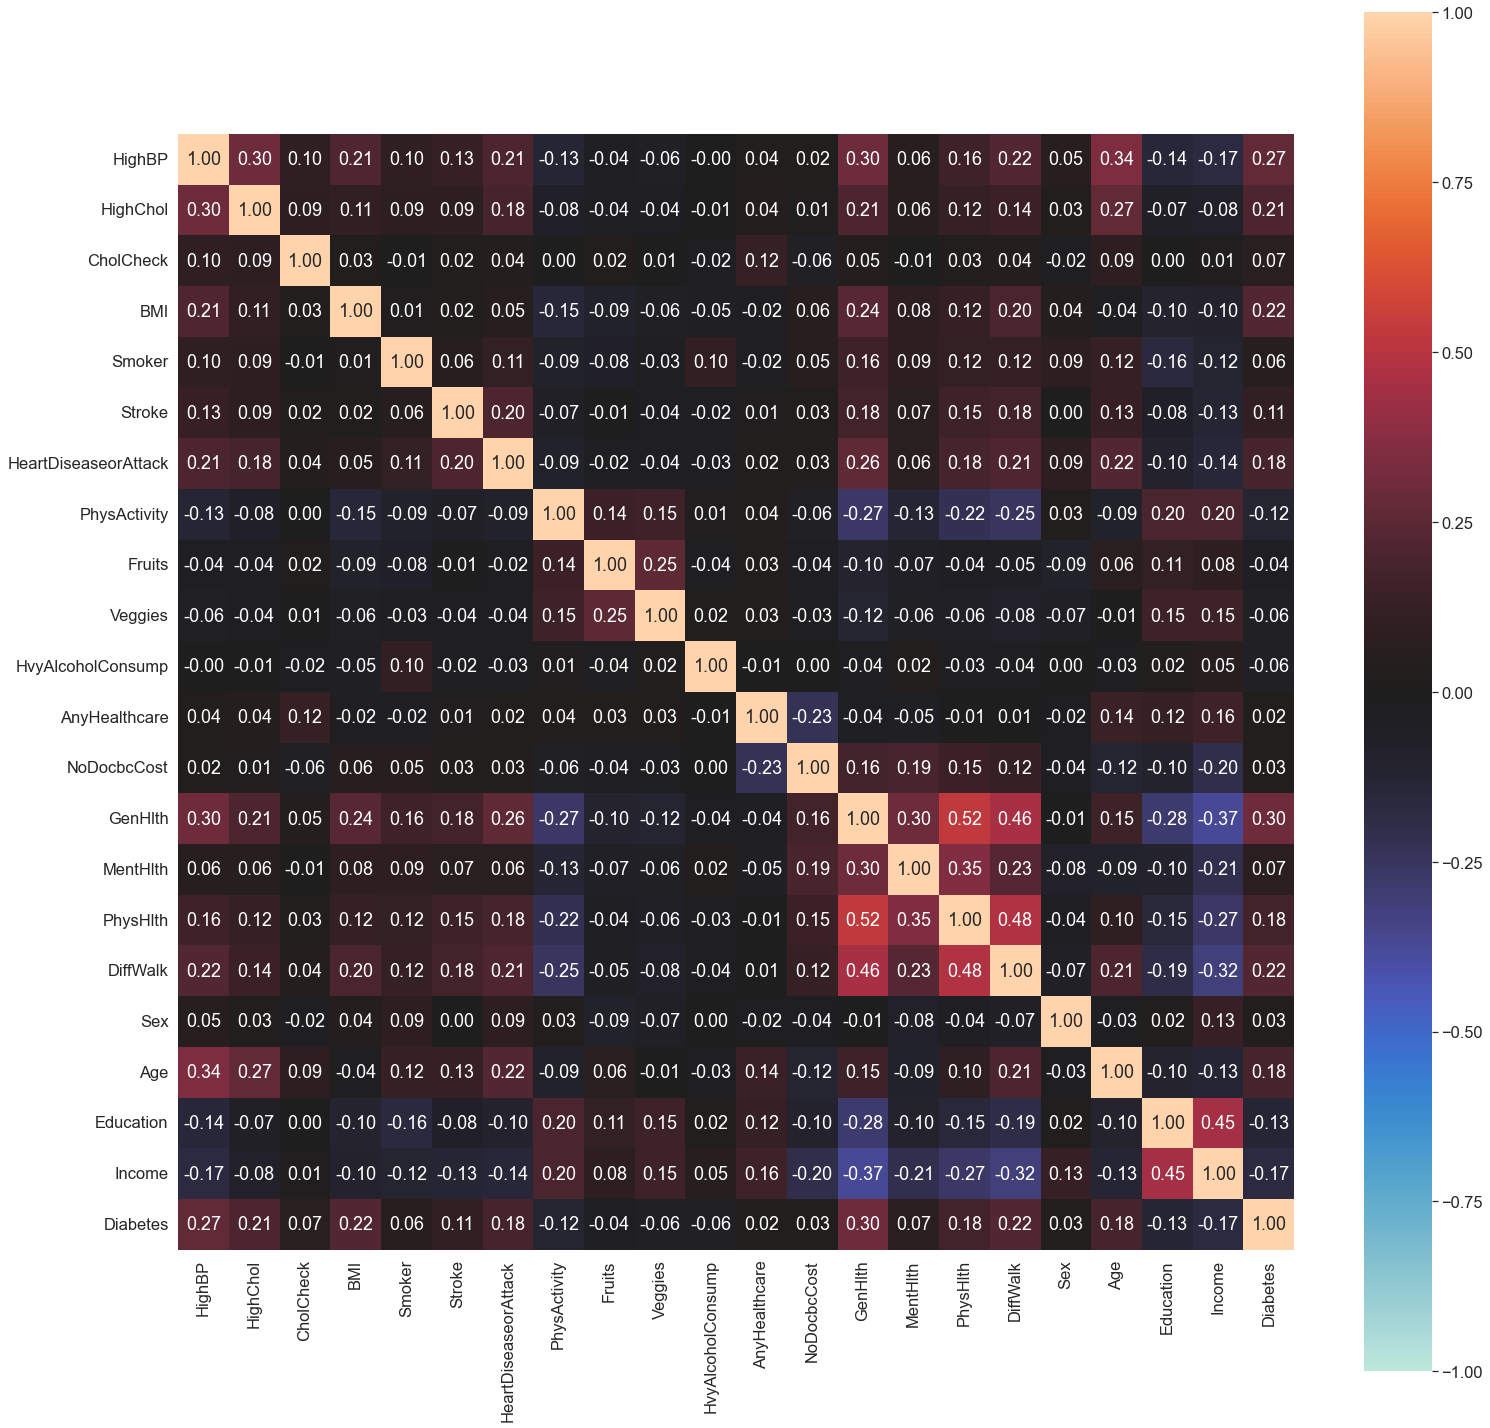

In [14]:
complete_correlation= associations(df, figsize=(25,25))

In [15]:
#save the result in a DataFrame
df_complete_corr = complete_correlation['corr']
df_complete_corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes
HighBP,1.00,0.30,0.10,0.21,0.10,0.13,0.21,-0.13,-0.04,-0.06,-0.00,0.04,0.02,0.30,0.06,0.16,0.22,0.05,0.34,-0.14,-0.17,0.27
HighChol,0.30,1.00,0.09,0.11,0.09,0.09,0.18,-0.08,-0.04,-0.04,-0.01,0.04,0.01,0.21,0.06,0.12,0.14,0.03,0.27,-0.07,-0.08,0.21
CholCheck,0.10,0.09,1.00,0.03,-0.01,0.02,0.04,0.00,0.02,0.01,-0.02,0.12,-0.06,0.05,-0.01,0.03,0.04,-0.02,0.09,0.00,0.01,0.07
BMI,0.21,0.11,0.03,1.00,0.01,0.02,0.05,-0.15,-0.09,-0.06,-0.05,-0.02,0.06,0.24,0.08,0.12,0.20,0.04,-0.04,-0.10,-0.10,0.22
Smoker,0.10,0.09,-0.01,0.01,1.00,0.06,0.11,-0.09,-0.08,-0.03,0.10,-0.02,0.05,0.16,0.09,0.12,0.12,0.09,0.12,-0.16,-0.12,0.06
Stroke,0.13,0.09,0.02,0.02,0.06,1.00,0.20,-0.07,-0.01,-0.04,-0.02,0.01,0.03,0.18,0.07,0.15,0.18,0.00,0.13,-0.08,-0.13,0.11
HeartDiseaseorAttack,0.21,0.18,0.04,0.05,0.11,0.20,1.00,-0.09,-0.02,-0.04,-0.03,0.02,0.03,0.26,0.06,0.18,0.21,0.09,0.22,-0.10,-0.14,0.18
PhysActivity,-0.13,-0.08,0.00,-0.15,-0.09,-0.07,-0.09,1.00,0.14,0.15,0.01,0.04,-0.06,-0.27,-0.13,-0.22,-0.25,0.03,-0.09,0.20,0.20,-0.12
Fruits,-0.04,-0.04,0.02,-0.09,-0.08,-0.01,-0.02,0.14,1.00,0.25,-0.04,0.03,-0.04,-0.10,-0.07,-0.04,-0.05,-0.09,0.06,0.11,0.08,-0.04
Veggies,-0.06,-0.04,0.01,-0.06,-0.03,-0.04,-0.04,0.15,0.25,1.00,0.02,0.03,-0.03,-0.12,-0.06,-0.06,-0.08,-0.07,-0.01,0.15,0.15,-0.06
